# Reference:
Implemented:
https://towardsdatascience.com/detection-of-price-support-and-resistance-levels-in-python-baedc44c34c9

Alternative:
https://medium.com/@judopro/using-machine-learning-to-programmatically-determine-stock-support-and-resistance-levels-9bb70777cf8e 

In [6]:
import pandas as pd
import numpy as np
import yfinance
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mpl_dates
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 7]
plt.rc('font', size=14)

In [11]:
# Download S&P 500 daily data
ticker = yfinance.Ticker('SPY')
df = ticker.history(interval="1d", start="2020-01-01", end="2021-02-15")
df['Date'] = pd.to_datetime(df.index)
df['Date'] = df['Date'].apply(mpl_dates.date2num)
df = df.loc[:,['Date', 'Open', 'High', 'Low', 'Close']]
df.head()


,Date,Open,High,Low,Close
Date,,,,,
2019-12-31,18261.0,314.653899,316.224573,314.280860,315.959503
2020-01-02,18263.0,317.608702,318.933959,316.617208,318.914307
2020-01-03,18264.0,315.272366,317.706913,315.213469,316.499451
2020-01-06,18267.0,314.614632,317.795256,314.487011,317.706909
2020-01-07,18268.0,317.098230,317.608716,316.332531,316.813568


In [15]:
# Two functions that identify the 4-candles fractals
def isSupport(df,i):
    support = df['Low'][i] < df['Low'][i-1]  and df['Low'][i] < df['Low'][i+1] and df['Low'][i+1] < df['Low'][i+2] and df['Low'][i-1] < df['Low'][i-2]
    return support

def isResistance(df,i):
    resistance = df['High'][i] > df['High'][i-1]  and df['High'][i] > df['High'][i+1] and df['High'][i+1] > df['High'][i+2] and df['High'][i-1] > df['High'][i-2]
    return resistance

In [16]:
# Create a list that will contain the levels we find. Each level is a tuple whose first element is the index of the signal candle and the second element is the price value.
levels = []
for i in range(2,df.shape[0]-2):
    if isSupport(df,i):
        levels.append((i,df['Low'][i]))
    elif isResistance(df,i):
        levels.append((i,df['High'][i]))

In [19]:
# Define a function that plots price and key levels together
def plot_all():
    fig, ax = plt.subplots()
    candlestick_ohlc(ax,df.values,width=0.6, \
        colorup='green', colordown='red', alpha=0.8)
    date_format = mpl_dates.DateFormatter('%d %b %Y')
    ax.xaxis.set_major_formatter(date_format)
    fig.autofmt_xdate()
    fig.tight_layout()
    for level in levels:
        plt.hlines(level[1],xmin=df['Date'][level[0]],\
            xmax=max(df['Date']),colors='blue')
    fig.show()



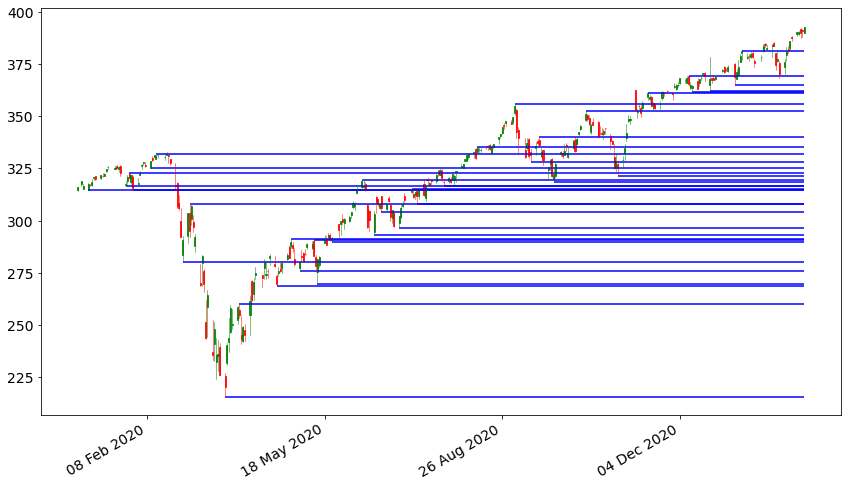

In [20]:
# Plot and see
plot_all()

We have been able to detect the major rejection levels, but there’s still some noise. Some levels are over others, but they are essentially the same level.

We can clean this noise modifying the function that detects key levels. If a level is near another one, it will be discarded. We must decide what “near” means, then. We can say that a level is near another one if their distance is less than the average candle size in our chart (i.e. the average difference between high and low prices in a candle). This will give us a rough estimate of volatility.

In [21]:
s =  np.mean(df['High'] - df['Low'])
# Define a function that, given a price value, returns False if it is near some previously discovered key level.

def isFarFromLevel(l):
   return np.sum([abs(l-x) < s  for x in levels]) == 0

# Scan the price history looking for key levels using this function as a filter.
levels = []
for i in range(2,df.shape[0]-2):
    if isSupport(df,i):
        l = df['Low'][i]
        if isFarFromLevel(l):
            levels.append((i,l))
    elif isResistance(df,i):
        l = df['High'][i]
        if isFarFromLevel(l):
            levels.append((i,l))

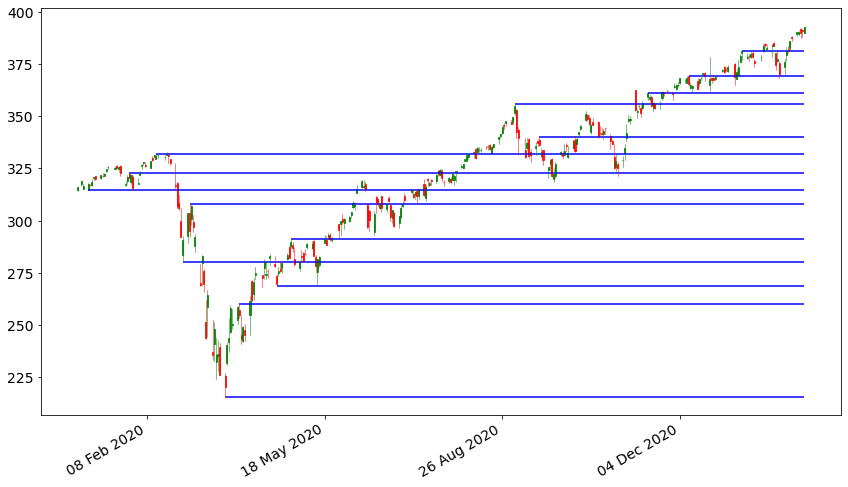

In [22]:
plot_all()